In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd 
import re 
import seaborn as sns
import numpy as np
import os # accessing directory structure
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon');
from nltk import tokenize
import warnings
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from textblob import TextBlob
from nltk.corpus import stopwords
stop = stopwords.words('english');
from sklearn.metrics import confusion_matrix

#tweet_path = '/home/brendon/Desktop/Dissertation/Data Collection/v2/ALLTweets.csv'
#bitcoin_path = '/home/brendon/Desktop/Dissertation/Data Collection/v2/BTC-USD_CBPrices.csv'
tweet_path = 'C:/Users/agarwaln/Downloads/Data-20190604T125520Z-001/Data/tweets.csv'
bitcoin_path = 'C:/Users/agarwaln/Downloads/Data-20190604T125520Z-001/Data/bit_price.csv'

scaling_flag = True;
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
hours_to_predict = 6;  ## numbers of past hours to predict then next hour's open price.

plotly.tools.set_credentials_file(username='mnitin3', api_key='B54WiHGWbE8AHZYK3h5A');
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#pip install -U textblob
os.system("python -m textblob.download_corpora");

Using TensorFlow backend.
C:\Users\agarwaln\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\agarwaln\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
## Reading the source data
tweets = pd.read_csv(tweet_path,  delimiter=',',  error_bad_lines=False);
bitcoin = pd.read_csv(bitcoin_path,  delimiter=',',  error_bad_lines=False);
print("\nTweets Data:\n\n",tweets.head(2));
print("\n\nBitcoin Data:\n",bitcoin.head(2));


Tweets Data:

              id  conversation_id     created_at        date      time timezone       user_id      username           name place                                              tweet                    mentions                        urls photos  replies_count  retweets_count  likes_count  location      hashtags                                               link  retweet quote_url  video
0  1.091124e+18     1.090748e+18  1548979130000  2019-02-01  00:58:50      CET  2.562285e+07  jonharichman  Jonha Richman   NaN  Madame @Lagarde actually gives some pretty obj...  ['cidvicious2', 'lagarde']                          []     []              1               0            3       NaN  ['#bitcoin']  https://twitter.com/JonhaRichman/status/109112...      NaN       NaN      0
1  1.091122e+18     1.091122e+18  1548978769000  2019-02-01  00:52:49      CET  7.518583e+17   cashsupport   Cash Support   NaN  Hey there! At this time, it takes up to 72 hou...               ['lucdaboss']  ['

In [4]:
## Calculate Price Fluctuations
prices = bitcoin[['Date','open','close']]
prices['Date'] = pd.to_datetime(prices.Date, unit='s');
prices = prices.sort_values(by=['Date']);
prices = prices.rename(columns = {'Date':'date_cnv'})
prices['date_cnv']  = prices['date_cnv'].apply(lambda x: x.strftime('%Y-%m-%d'));
prices['date_cnv'] = pd.to_datetime(prices ['date_cnv']);
prices_first_open = prices.groupby('date_cnv')['open'].agg(['first']);
prices_last_close = prices.groupby('date_cnv')['close'].agg(['last']);
prices_df = pd.merge(prices_first_open, prices_last_close, how='inner', on='date_cnv');
prices_df['Date'] =  prices_df.index;
prices_df = prices_df.rename(columns = {'first':'open', 'last':'close'});

prices_df['price_fluct']=(prices_df['close']-prices_df['open'])/prices_df['open']
for i in prices_df.index:
    if prices_df.at[i,'price_fluct'] > 0.001:
        prices_df.at[i,'price_fluct'] = '1';
    elif prices_df.at[i,'price_fluct'] < -0.001:
        prices_df.at[i,'price_fluct'] = '-1';
    else:
        prices_df.at[i,'price_fluct'] = '0'; 
        
prices_df['price_fluct']=prices_df['price_fluct'].astype(int);
target_series = prices_df.filter(['Date','price_fluct'], axis=1);
target_series['date_cnv']  = target_series['Date'].apply(lambda x: x.strftime('%Y-%m-%d'));
target_series = target_series.drop(['Date','date_cnv'], axis=1)
print("\nBitcoin Price fluctuations - Daily:\n ", target_series.head(10));


Bitcoin Price fluctuations - Daily:
              price_fluct
date_cnv               
2015-01-08           -1
2015-01-13            0
2015-01-14           -1
2015-01-15            1
2015-01-16           -1
2015-01-17           -1
2015-01-19            1
2015-01-20            1
2015-01-21            1
2015-01-22           -1


In [5]:
tweets['date_time']=pd.to_datetime(tweets['date'] + ' ' + tweets['time'])
tweets['tweet']=tweets['tweet'].astype(str)
tweets=tweets[['date','date_time','id','link','conversation_id','username','tweet']]
tweets['tweet_len'] =  tweets['tweet'].apply(len)
tweets['tweet_len'].describe();
print(tweets.head());

         date           date_time            id                                               link  conversation_id        username                                              tweet  tweet_len
0  2019-02-01 2019-02-01 00:58:50  1.091124e+18  https://twitter.com/JonhaRichman/status/109112...     1.090748e+18    jonharichman  Madame @Lagarde actually gives some pretty obj...        176
1  2019-02-01 2019-02-01 00:52:49  1.091122e+18  https://twitter.com/CashSupport/status/1091122...     1.091122e+18     cashsupport  Hey there! At this time, it takes up to 72 hou...        277
2  2019-02-01 2019-02-01 00:46:07  1.091120e+18  https://twitter.com/ItalyinSanFran/status/1091...     1.091120e+18  italyinsanfran  #Networking event at #SVIEC (The Silicon Valle...        298
3  2019-02-01 2019-02-01 00:21:25  1.091114e+18  https://twitter.com/ProfFaustus/status/1091114...     1.090995e+18     proffaustus  You cannot use the early Bitcoin software to v...        141
4  2019-02-01 2019-02-01 00:17

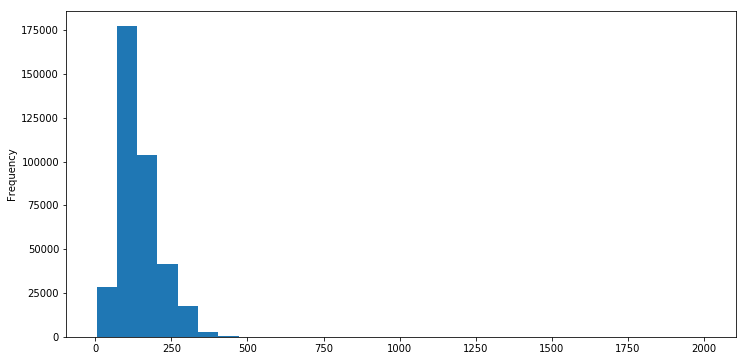

In [6]:
tweets['tweet_len'].plot(kind='hist', bins=30, figsize=(12,6))
plt.show()

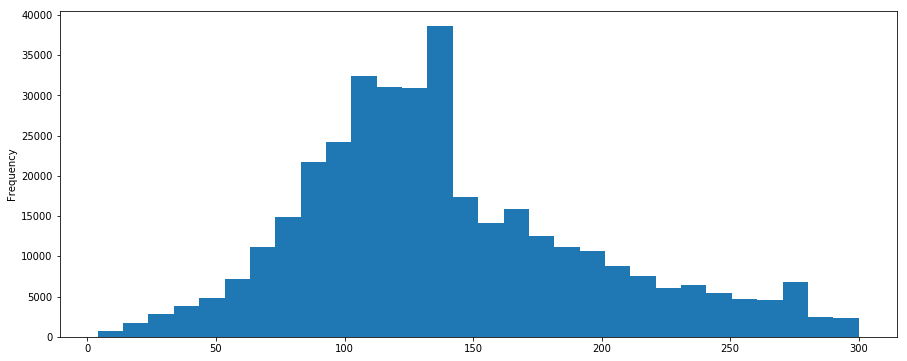

In [7]:
tweet_df = tweets.drop(tweets[tweets['tweet_len'] > 300].index)
tweet_df['tweet_len'].plot(kind='hist', bins=30, figsize=(15,6))
plt.show()

In [8]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing: stop words, links, special characters using regex.
    Args:
        tweet: DataFrame column 'text'
    Returns:
        
    '''
    tweet = str(tweet)
    tweet = tweet.lower()
    tweet = [word for word in tweet.split() if word not in stop]
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", str(tweet)).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet using textblob.
    Args:
        tweet:
    Returns:
    
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [9]:
tweet_df['text_cleaned'] = tweet_df['tweet'].apply(clean_tweet)
tweet_df['sentiment_score_textBlob'] = tweet_df['text_cleaned'].apply(analyze_sentiment);
print(tweet_df.head(2));

         date           date_time            id                                               link  conversation_id      username                                              tweet  tweet_len                                       text_cleaned  sentiment_score_textBlob
0  2019-02-01 2019-02-01 00:58:50  1.091124e+18  https://twitter.com/JonhaRichman/status/109112...     1.090748e+18  jonharichman  Madame @Lagarde actually gives some pretty obj...        176  madame actually gives pretty objective compell...                         1
1  2019-02-01 2019-02-01 00:52:49  1.091122e+18  https://twitter.com/CashSupport/status/1091122...     1.091122e+18   cashsupport  Hey there! At this time, it takes up to 72 hou...        277  hey there time takes 72 hours account verified...                         0


In [10]:
# https://github.com/Sapphirine/Using-News-to-Predict-Stock-Movement
 
analyser = SentimentIntensityAnalyzer()
def senti_score_udf(sentence):
    snt = analyser.polarity_scores(sentence)
#     return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
    return (snt['compound'])

In [11]:
tweet_df['sentiment_score_vader'] = tweet_df['text_cleaned'].apply(senti_score_udf)
tweet_df.head(2)

date           date_time            id                                               link  conversation_id      username                                              tweet  tweet_len                                       text_cleaned  sentiment_score_textBlob  sentiment_score_vader
0  2019-02-01 2019-02-01 00:58:50  1.091124e+18  https://twitter.com/JonhaRichman/status/109112...     1.090748e+18  jonharichman  Madame @Lagarde actually gives some pretty obj...        176  madame actually gives pretty objective compell...                         1                 0.7650
1  2019-02-01 2019-02-01 00:52:49  1.091122e+18  https://twitter.com/CashSupport/status/1091122...     1.091122e+18   cashsupport  Hey there! At this time, it takes up to 72 hou...        277  hey there time takes 72 hours account verified...                         0                 0.6597

In [12]:
# pre-processing to count number of tweets per sentiment type
tweet_df["pos_tweet_textBlob"] = np.where(tweet_df["sentiment_score_textBlob"] > 0, 1, 0)

#tweet_df["neg_sentiment_tweet"] = np.where(tweet_df["sentiment"] < 0, 1, tweet_df["pos_sentiment_tweet"])
tweet_df["neu_tweet_textBlob"] = np.where(tweet_df["sentiment_score_textBlob"] == 0, 1, 0)
tweet_df["neg_tweet_textBlob"] = np.where(tweet_df["sentiment_score_textBlob"] < 0, 1, 0)

# pre-processing to count number of tweets per sentiment type
tweet_df["pos_tweet_vader"] = np.where(tweet_df["sentiment_score_vader"] > 0, 1, 0)

#tweet_df["neg_sentiment_tweet"] = np.where(tweet_df["sentiment"] < 0, 1, tweet_df["pos_sentiment_tweet"])
tweet_df["neu_tweet_vader"] = np.where(tweet_df["sentiment_score_vader"] == 0, 1, 0)
tweet_df["neg_tweet_vader"] = np.where(tweet_df["sentiment_score_vader"] < 0, 1, 0)
tweet_df.head()

date           date_time            id                                               link  conversation_id        username                                              tweet  tweet_len                                       text_cleaned  sentiment_score_textBlob  sentiment_score_vader  pos_tweet_textBlob  neu_tweet_textBlob  neg_tweet_textBlob  pos_tweet_vader  neu_tweet_vader  neg_tweet_vader
0  2019-02-01 2019-02-01 00:58:50  1.091124e+18  https://twitter.com/JonhaRichman/status/109112...     1.090748e+18    jonharichman  Madame @Lagarde actually gives some pretty obj...        176  madame actually gives pretty objective compell...                         1                 0.7650                   1                   0                   0                1                0                0
1  2019-02-01 2019-02-01 00:52:49  1.091122e+18  https://twitter.com/CashSupport/status/1091122...     1.091122e+18     cashsupport  Hey there! At this time, it takes up to 72 hou...        277  hey there time takes 72 hours account verified...                         0                 0.6597                   0                   1                   0                1                0                0
2  2019-02-01 2019-02-01 00:46:07  1.091120e+18  https://twitter.com/ItalyinSanFran/status/1091...     1.091120e+18  italyinsanfran  #Networking event at #SVIEC (The Silicon Valle...        298  networking event sviec the silicon valley ital...                         1                 0.6486                   1                   0                   0                1                0                0
3  2019-02-01 2019-02-01 00:21:25  1.091114e+18  https://twitter.com/ProfFaustus/status/1091114...     1.090995e+18     proffaustus  You cannot use the early Bitcoin software to v...        141  cannot use early bitcoin software validate btc...                         1                -0.0516                   1                   0                   0                0                0                1
4  2019-02-01 2019-02-01 00:17:47  1.091113e+18  https://twitter.com/ETFEdgeCNBC/status/1091113...     1.091113e+18     etfedgecnbc  Cboe resubmits filing for bitcoin ETF after pu...        219  cboe resubmits filing bitcoin etf pulling due ...                        -1                 0.0000                   0                   0                   1                0                1                0

In [13]:
tweet_df_sumd = tweet_df.groupby(pd.Grouper(key='date', sort=True)).sum()
tweet_df_sumd.reset_index(level=0, inplace=True)
target_series.reset_index(level=0, inplace=True)
tweet_df_sumd['date'] = pd.to_datetime(tweet_df_sumd ['date']);
tweet_df_sumd['pos-neg_textBlob'] = tweet_df_sumd['pos_tweet_textBlob'] - tweet_df_sumd['neg_tweet_textBlob']
tweet_df_sumd['pos-neg_vader'] = tweet_df_sumd['pos_tweet_vader'] - tweet_df_sumd['neg_tweet_vader']
tweet_df_sumd['neg-plus-neu_textBlob'] = tweet_df_sumd['neu_tweet_textBlob'] + tweet_df_sumd['neg_tweet_textBlob']
tweet_df_sumd['posNeg-plusNeu_textBlob'] = tweet_df_sumd['pos_tweet_textBlob'] - tweet_df_sumd['neg-plus-neu_textBlob']
tweet_df_sumd['neg-plus-neu_vader'] = tweet_df_sumd['neu_tweet_vader'] + tweet_df_sumd['neg_tweet_vader']
tweet_df_sumd['posNeg-plusNeu_vader'] = tweet_df_sumd['pos_tweet_vader'] - tweet_df_sumd['neg-plus-neu_vader'];
tweet_df_sumd.head(2);

In [14]:
target_series.head()
prices_pol_agg = pd.merge(tweet_df_sumd, target_series, how='left', right_on='date_cnv',left_on='date');
prices_pol_agg.head()
print("\nRows before removing nulls:", prices_pol_agg.shape[0]);
prices_polartiy_agg = prices_pol_agg.dropna();
print("\nRows After removing nulls:", prices_polartiy_agg.shape[0]);
prices_polartiy_agg.index = prices_polartiy_agg['date']
prices_polartiy_agg = prices_polartiy_agg[['tweet_len', 'sentiment_score_textBlob', 'sentiment_score_vader', 
                                           'pos_tweet_textBlob','neu_tweet_textBlob','neg_tweet_textBlob','pos_tweet_vader','neu_tweet_vader'
                                           ,'neg_tweet_vader','pos-neg_textBlob','pos-neg_vader','neg-plus-neu_textBlob',
                                           'posNeg-plusNeu_textBlob','neg-plus-neu_vader','posNeg-plusNeu_vader','price_fluct']]
prices_polartiy_agg.head()


Rows before removing nulls: 1463

Rows After removing nulls: 1462


tweet_len  sentiment_score_textBlob  sentiment_score_vader  pos_tweet_textBlob  neu_tweet_textBlob  neg_tweet_textBlob  pos_tweet_vader  neu_tweet_vader  neg_tweet_vader  pos-neg_textBlob  pos-neg_vader  neg-plus-neu_textBlob  posNeg-plusNeu_textBlob  neg-plus-neu_vader  posNeg-plusNeu_vader  price_fluct
date                                                                                                                                                                                                                                                                                                                         
2015-01-31      19114                        54                21.0710                  72                  56                  18               62               58               26                54             36                     74                       -2                  84                   -22         -1.0
2015-02-01      18902                        46                21.8656                  74                  56                  28               76               48               34                46             42                     84                      -10                  82                    -6          1.0
2015-02-02      29120                        38                27.7604                  76                 120                  38              108               86               40                38             68                    158                      -82                 126                   -18          1.0
2015-02-03      48988                       100                47.1044                 140                 232                  40              172              152               88               100             84                    272                     -132                 240                   -68         -1.0
2015-02-04      49804                        46                48.0608                 108                 236                  62              168              158               80                46             88                    298                     -190                 238                   -70         -1.0

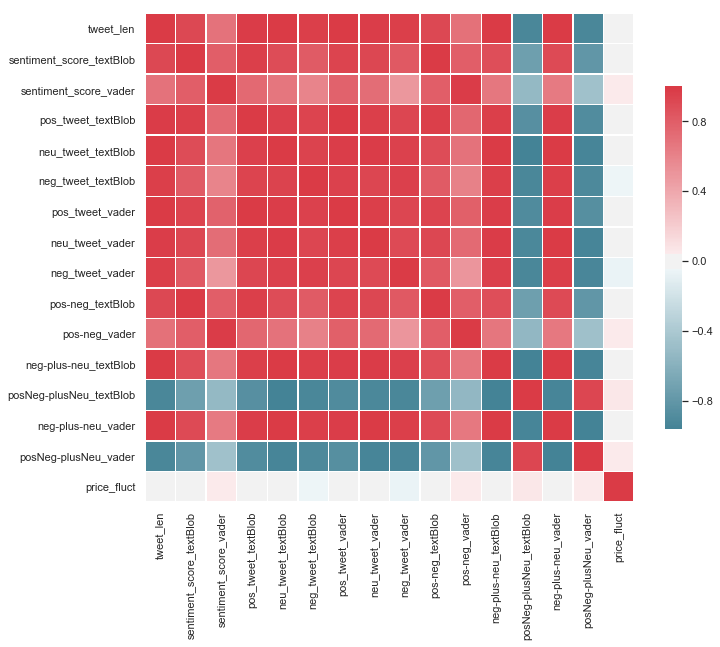

In [15]:
############################# Relationship Plots ##########################
# Understanding Correlations among the variables 
cor = prices_polartiy_agg.corr();

sns.set(style="white");
f, ax = plt.subplots(figsize=(11, 9));
cmap = sns.diverging_palette(220, 10, as_cmap=True);
ax =sns.heatmap(cor, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7});
plt.show();


In [16]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1];
    #print("\nnvars: ", n_vars, "\n");
    df = pd.DataFrame(data);
    cols, names = list(), list();
	
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i));
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)];
	
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i));
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)];
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)];
    agg = np.concatenate(cols, axis=1);
    agg = pd.DataFrame(agg)
    agg.columns = names;
    if dropnan:
        agg.dropna(inplace=True);
    return agg

In [36]:
#values = prices_polartiy_agg.values;
#cols = prices_polartiy_agg.columns.tolist();
#ind_y = cols.index('price_fluct');
#print(cols, ind_y)
####################### LSTM Modelling #############################

values = prices_polartiy_agg.values;
cols = prices_polartiy_agg.columns.tolist();
cols = cols[-1:] + cols[:-1];
print(cols,"\n\n");
prices_polartiy_agg = prices_polartiy_agg[cols];
#print(prices_polartiy_agg.head());

Y = prices_polartiy_agg['price_fluct']
X = prices_polartiy_agg[cols[1:]]
print(Y[:3],"\n\n", X[:1])
print("\n", type(Y.as_matrix()))

['neg_tweet_vader', 'pos-neg_textBlob', 'pos-neg_vader', 'neg-plus-neu_textBlob', 'posNeg-plusNeu_textBlob', 'neg-plus-neu_vader', 'posNeg-plusNeu_vader', 'price_fluct', 'tweet_len', 'sentiment_score_textBlob', 'sentiment_score_vader', 'pos_tweet_textBlob', 'neu_tweet_textBlob', 'neg_tweet_textBlob', 'pos_tweet_vader', 'neu_tweet_vader'] 


date
2015-01-31   -1.0
2015-02-01    1.0
2015-02-02    1.0
Name: price_fluct, dtype: float64 

             pos-neg_textBlob  pos-neg_vader  neg-plus-neu_textBlob  posNeg-plusNeu_textBlob  neg-plus-neu_vader  posNeg-plusNeu_vader  price_fluct  tweet_len  sentiment_score_textBlob  sentiment_score_vader  pos_tweet_textBlob  neu_tweet_textBlob  neg_tweet_textBlob  pos_tweet_vader  neu_tweet_vader
date                                                                                                                                                                                                                                                                

In [46]:
## Scaling

if scaling_flag:
    print("\nscaling flag is :",scaling_flag,"\n");
    scaler = MinMaxScaler(feature_range=(-1, 1));
    scaled = scaler.fit_transform(X.values);
else:
    print("\nscaling flag is :",scaling_flag,"\n");
    scaled = X.values;

print((scaled.shape))


scaling flag is : True 

(1462, 15)


In [61]:
n_hours = hours_to_predict; #adding hours lags creating number of observations 
n_features = scaled.shape[1] #Features in the dataset.
n_obs = n_hours*n_features
reframed = series_to_supervised(scaled, n_hours, 1);
reframed = reframed.dropna();
#print(reframed.head(1));

## Keeping backup of full data with index for understanding and debugging
reframed_with_index = reframed;
reframed_with_index.index = X.index[n_hours:];

values = reframed.values
n_train_hours = int(0.8*reframed.shape[0]);
print(n_train_hours)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print("Training data dimensions: ", train.shape,"\tTest data dimensions: ",test.shape);

1164
Training data dimensions:  (1164, 105) 	Test data dimensions:  (292, 105)


In [67]:
#Removing first n_hours observations from  Y, as we dropped them in X during Series to supervised step
y = Y[n_hours:]

# split into input and outputs
train_X= train[:, :n_obs]
test_X = test[:, :n_obs];
train_y = y.values[:n_train_hours]
test_y = y.values[n_train_hours:]
print("Test Y\n", test_y[:10]);
print("Train Y\n", train_y[:10]);
print("Test X\n", test_X[:1]);
print("Train X\n", train_X[:1]);
#print(test_y.shape)
#print(n_train_hours)
#print(Y.shape)
#print(1462-1164)

Test Y
 [ 1. -1. -1.  1.  1.  1.  1. -1.  1.  1.]
Train Y
 [ 1.  1. -1. -1. -1. -1.  1.  1.  1. -1.]
Test X
 [[-0.7753059  -0.41666667 -0.84963024  0.68339768 -0.85899514  0.79142136
  -1.         -0.83638979 -0.7753059  -0.28030549 -0.86929884 -0.83973655
  -0.8699187  -0.85365854 -0.86046512 -0.82202447 -0.56321839 -0.71569433
   0.49343629 -0.72528363  0.57779647  1.         -0.72643467 -0.82202447
  -0.36522144 -0.81484003 -0.72777168 -0.67154472 -0.80069686 -0.75946844
  -0.80645161 -0.43390805 -0.79622021  0.58301158 -0.81604538  0.72245585
   1.         -0.79544186 -0.80645161 -0.27891933 -0.86929884 -0.78375412
  -0.82439024 -0.8369338  -0.81395349 -0.63515017 -0.39655172 -0.73541495
   0.63861004 -0.70502431  0.57106812  1.         -0.68851392 -0.63515017
  -0.25581973 -0.7195371  -0.73874863 -0.71707317 -0.77142857 -0.67707641
  -0.72636263 -0.39942529 -0.74609696  0.6046332  -0.74473258  0.65517241
  -1.         -0.72582074 -0.72636263 -0.27004265 -0.76718856 -0.75960483
  -

In [68]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)


(1164, 90)
(1164,)
(292, 90)
(292,)


In [69]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

num_classes = len(np.unique(train_y));
y_train_mod = keras.utils.to_categorical(train_y, num_classes);
y_test_mod = keras.utils.to_categorical(test_y, num_classes);

## Target Varaible has been encoded. three columns have a flag for our three classes: -1,0,1.
print("Sample target column:: Train: \n",y_train_mod[:5] );
print("Sample target column:: Test: \n",y_test_mod[:5]);

(1164, 6, 15) (1164,) (292, 6, 15) (292,)
Sample target column:: Train: 
 [[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Sample target column:: Test: 
 [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [70]:
# design network
np.random.seed(333);
model = Sequential();
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2]),activation='tanh'));
model.add(Dropout(.1));
model.add(Dense(350,activation='tanh'));
#model.add(Dropout(.5));
model.add(Dense(200,activation='tanh'));
model.add(Dropout(.2));
model.add(Dense(100,activation='tanh'));
#model.add(Dropout(.5));
model.add(Dense(150,activation='tanh'));
model.add(Dropout(.2));
model.add(Dense(25));
#model.add(Dropout(.5));
model.add(Dense(num_classes, activation = 'softmax'));
model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam', metrics=['accuracy']);
print(model);

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [71]:
# fit network
history = model.fit(train_X, y_train_mod , epochs=50, batch_size=50, validation_data=(test_X, y_test_mod), verbose=2, shuffle=True, validation_split=0.2);

Instructions for updating:
Use tf.cast instead.
Train on 1164 samples, validate on 292 samples
Epoch 1/50
 - 9s - loss: 0.9591 - acc: 0.4837 - val_loss: 0.8202 - val_acc: 0.4726
Epoch 2/50
 - 5s - loss: 0.8794 - acc: 0.5026 - val_loss: 0.8238 - val_acc: 0.4726
Epoch 3/50
 - 5s - loss: 0.8750 - acc: 0.5275 - val_loss: 0.7865 - val_acc: 0.4760
Epoch 4/50
 - 6s - loss: 0.8585 - acc: 0.5258 - val_loss: 0.8444 - val_acc: 0.4726
Epoch 5/50
 - 5s - loss: 0.8706 - acc: 0.5129 - val_loss: 0.7891 - val_acc: 0.4726
Epoch 6/50
 - 5s - loss: 0.8634 - acc: 0.5095 - val_loss: 0.8163 - val_acc: 0.4726
Epoch 7/50
 - 5s - loss: 0.8553 - acc: 0.5241 - val_loss: 0.8194 - val_acc: 0.4726
Epoch 8/50
 - 5s - loss: 0.8551 - acc: 0.5361 - val_loss: 0.8095 - val_acc: 0.4726
Epoch 9/50
 - 5s - loss: 0.8512 - acc: 0.5249 - val_loss: 0.7892 - val_acc: 0.4795
Epoch 10/50
 - 6s - loss: 0.8632 - acc: 0.5086 - val_loss: 0.8491 - val_acc: 0.4795
Epoch 11/50
 - 5s - loss: 0.8609 - acc: 0.5258 - val_loss: 0.8172 - val_ac

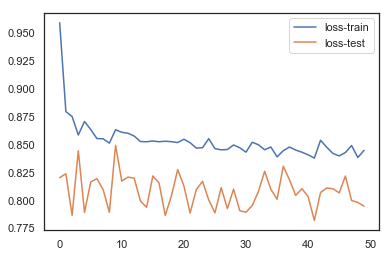

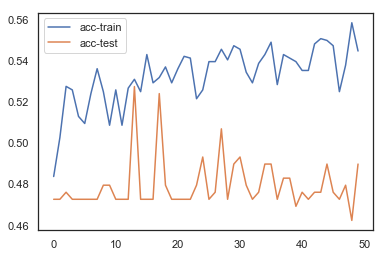

In [72]:
## Ploting the model training performance
plt.plot(history.history['loss'], label='loss-train')
plt.plot(history.history['val_loss'], label='loss-test')
plt.legend() 
plt.show();

## Ploting the model training performance
plt.plot(history.history['acc'], label='acc-train')
plt.plot(history.history['val_acc'], label='acc-test')
plt.legend() 
plt.show();

In [74]:
## Decoding Class from prediction
yhat = model.predict(test_X);
yhat_class = yhat.argmax(axis=-1);
yhat_class = np.where(yhat_class==2, -1, yhat_class); 
result = df = pd.DataFrame({'Actual':test_y, 'Predicted':yhat_class})
print(result);

     Actual  Predicted
0       1.0          1
1      -1.0          1
2      -1.0          1
3       1.0          1
4       1.0          1
5       1.0          1
6       1.0          1
7      -1.0         -1
8       1.0          1
9       1.0          1
10     -1.0          1
11      1.0          1
12     -1.0          1
13      1.0          1
14      1.0          1
15     -1.0          1
16     -1.0          1
17      1.0          1
18      1.0          1
19     -1.0          1
20      1.0          1
21     -1.0          1
22     -1.0          1
23     -1.0          1
24      1.0          1
25     -1.0         -1
26     -1.0          1
27      1.0          1
28      1.0         -1
29     -1.0         -1
..      ...        ...
262     1.0          1
263    -1.0          1
264     1.0          1
265    -1.0          1
266     1.0          1
267    -1.0          1
268    -1.0          1
269     1.0          1
270    -1.0          1
271     1.0          1
272    -1.0          1
273    -1.0

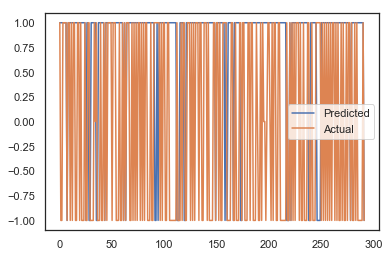

In [75]:
## Actual vs Predicted
## Ploting the model training performance
plt.plot(yhat_class, label='Predicted')
plt.plot(test_y, label='Actual')
plt.legend() 
plt.show()

In [76]:
## Result Accuracy:
cm = confusion_matrix(pd.DataFrame(yhat_class), pd.DataFrame(test_y));
acc = np.sum(np.diagonal(cm))/np.sum(cm);
print("Test Accuracy: ", round(acc*100,2), "%");

Test Accuracy:  48.97 %
